In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import numpy as np
from tqdm import tqdm
from collections import defaultdict

import matplotlib.pyplot as plt

import sys; sys.path.append('../../PGDL/sample_code_submission/')
from internal_rep.matrix_funcs import \
    get_KF_Schatten_norms, \
    compute_complexity, \
    get_df_tau, \
    evalues_from_regions, \
    get_local_rad_bound

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

n_train_sample = 4000

def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

# Train pipeline
ds_train = ds_train.take(n_train_sample)
ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

# Test pipeline
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

## Model Definitions

In [4]:
# Source https://github.com/lilianweng/generalization-experiment/blob/master/utils.py
def dense_nn(inputs, layers_sizes, name="fc", reuse=False, output_fn=None,
             dropout_keep_prob=None, training=True):
    logging.info(f"Building mlp {name} | sizes: {[inputs.shape[0]] + layers_sizes}")
    with tf.variable_scope(name, reuse=reuse):
        out = inputs
        for i, size in enumerate(layers_sizes):
            if i > 0 and dropout_keep_prob is not None and training:
                # No dropout on the input layer.
                out = tf.nn.dropout(out, keep_prob=dropout_keep_prob)

            out = tf.layers.dense(
                out,
                size,
                kernel_initializer=tf.contrib.layers.xavier_initializer(),
                bias_initializer=tf.constant_initializer(0.0),
                name=name + '_l' + str(i),
                reuse=reuse,
                # Add relu activation only for internal layers.
                activation=tf.nn.relu if i < len(layers_sizes) - 1 else None,
            )

        if output_fn:
            out = output_fn(out)

    return out

## Run ReLu Net

In [16]:
def fit_model(model, n_epochs, optimizer, loss_fn, metric, metric_dict={}):
    @tf.function
    def _train_step(x, y):
        with tf.GradientTape() as tape:
            logits = model(x, training=True)
            loss_value = loss_fn(y, logits)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Update training metric
        metric.update_state(y, logits)
        return loss_value

    # @tf.function
    def _test_step(x, y):
        logits = model(x, training=False)
        # Update val metrics
        metric.update_state(y, logits)
        return logits, y

    model_results = defaultdict(list)
    
    for epoch in range(n_epochs):
        losses = []
        for step, (x_batch, y_batch) in enumerate(ds_train):
            loss_value = _train_step(x_batch, y_batch)
            losses.append(loss_value)
        model_results['train_loss'].append(np.mean(losses))
            
        # Display metrics at the end of each epoch.
        train_acc = metric.result()
        metric.reset_states()
        
        model_results['train_accuracy'].append(train_acc)
        
        # Run a validation loop at the end of each epoch.
        logit_list = []
        y_list = []
        for x_batch, y_batch in ds_test:
            logits, y = _test_step(x_batch, y_batch)
            logit_list.append(logits)
            y_list.append(y)
        y_list = tf.concat(y_list, axis=0)
        logit_list = tf.concat(logit_list, axis=0)
        model_results['test_ece'].append(tfp.stats.expected_calibration_error(10, logit_list, y_list))
        
            
        test_acc = metric.result()
        metric.reset_states()
        model_results['test_accuracy'].append(test_acc)
        
        # Get the complexity at the end of each epoch
        # Add model complexity
        internal_rep = []
        for x_batch, y_batch in ds_train:
            for layer in model.layers[:-1]:
                x_batch = layer(x_batch)
            internal_rep.append((x_batch.numpy() > 0).astype('bool'))
        internal_rep = np.vstack(internal_rep)
        evalues = evalues_from_regions(internal_rep)
        h_star, h_argmin = get_local_rad_bound(evalues, from_evalues=True)
        model_results['h*'].append(h_star)
        model_results['h_argmin'].append(h_argmin)
        model_results['n_activated_regions'].append(sum(evalues > 0))
        
        if epoch % 5 == 0:
            print(f"Epoch {epoch}: Training acc={train_acc:.3f}, Validation acc={test_acc:.3f}")
        
    return model, model_results

In [17]:
critical_n_units = int((n_train_sample * 10 - 10) / float(28 * 28 + 10))

n_units_to_test = sorted(set(
    list(range(critical_n_units - 7, critical_n_units + 4)) +
    list(range(5, 55, 5)) + list(range(50, 105, 10)) + [120, 150, 200]
))

results_dict = {}
for n_units in tqdm(n_units_to_test):
    total_params = (28 * 28 + 1) * n_units + (n_units + 1) * 10
    
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(n_units, activation='relu'),
      tf.keras.layers.Dense(10)
    ])
    
    n_epochs = 50
    optimizer = tf.keras.optimizers.Adam(0.001)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.SparseCategoricalAccuracy()
    
    model, model_results = fit_model(model, n_epochs, optimizer, loss_fn, metric)
    
    results_dict[total_params] = model_results

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 0: Training acc=0.199, Validation acc=0.283
Epoch 5: Training acc=0.721, Validation acc=0.729
Epoch 10: Training acc=0.803, Validation acc=0.799
Epoch 15: Training acc=0.840, Validation acc=0.826
Epoch 20: Training acc=0.859, Validation acc=0.837
Epoch 25: Training acc=0.872, Validation acc=0.845
Epoch 30: Training acc=0.879, Validation acc=0.851
Epoch 35: Training acc=0.883, Validation acc=0.854
Epoch 40: Training acc=0.890, Validation acc=0.857
Epoch 45: Training acc=0.896, Validation acc=0.861


  4%|▎         | 1/27 [00:14<06:05, 14.07s/it]

Epoch 0: Training acc=0.215, Validation acc=0.317
Epoch 5: Training acc=0.849, Validation acc=0.857
Epoch 10: Training acc=0.901, Validation acc=0.889
Epoch 15: Training acc=0.922, Validation acc=0.900
Epoch 20: Training acc=0.932, Validation acc=0.905
Epoch 25: Training acc=0.941, Validation acc=0.908
Epoch 30: Training acc=0.950, Validation acc=0.909
Epoch 35: Training acc=0.953, Validation acc=0.909
Epoch 40: Training acc=0.959, Validation acc=0.910
Epoch 45: Training acc=0.964, Validation acc=0.909


  7%|▋         | 2/27 [00:28<05:57, 14.32s/it]

Epoch 0: Training acc=0.397, Validation acc=0.600
Epoch 5: Training acc=0.878, Validation acc=0.877
Epoch 10: Training acc=0.915, Validation acc=0.901
Epoch 15: Training acc=0.938, Validation acc=0.912
Epoch 20: Training acc=0.952, Validation acc=0.915
Epoch 25: Training acc=0.957, Validation acc=0.916
Epoch 30: Training acc=0.965, Validation acc=0.918
Epoch 35: Training acc=0.971, Validation acc=0.917
Epoch 40: Training acc=0.979, Validation acc=0.918
Epoch 45: Training acc=0.980, Validation acc=0.917


 11%|█         | 3/27 [00:42<05:40, 14.17s/it]

Epoch 0: Training acc=0.396, Validation acc=0.640
Epoch 5: Training acc=0.883, Validation acc=0.880
Epoch 10: Training acc=0.919, Validation acc=0.901
Epoch 15: Training acc=0.937, Validation acc=0.908
Epoch 20: Training acc=0.950, Validation acc=0.910
Epoch 25: Training acc=0.958, Validation acc=0.912
Epoch 30: Training acc=0.965, Validation acc=0.910
Epoch 35: Training acc=0.972, Validation acc=0.911
Epoch 40: Training acc=0.976, Validation acc=0.914
Epoch 45: Training acc=0.980, Validation acc=0.913


 15%|█▍        | 4/27 [00:56<05:27, 14.22s/it]

Epoch 0: Training acc=0.449, Validation acc=0.738
Epoch 5: Training acc=0.902, Validation acc=0.899
Epoch 10: Training acc=0.934, Validation acc=0.912
Epoch 15: Training acc=0.947, Validation acc=0.915
Epoch 20: Training acc=0.958, Validation acc=0.914
Epoch 25: Training acc=0.967, Validation acc=0.914
Epoch 30: Training acc=0.976, Validation acc=0.913
Epoch 35: Training acc=0.982, Validation acc=0.913
Epoch 40: Training acc=0.985, Validation acc=0.915
Epoch 45: Training acc=0.988, Validation acc=0.916


 19%|█▊        | 5/27 [01:11<05:15, 14.33s/it]

Epoch 0: Training acc=0.453, Validation acc=0.717
Epoch 5: Training acc=0.906, Validation acc=0.890
Epoch 10: Training acc=0.935, Validation acc=0.907
Epoch 15: Training acc=0.953, Validation acc=0.911
Epoch 20: Training acc=0.966, Validation acc=0.911
Epoch 25: Training acc=0.970, Validation acc=0.915
Epoch 30: Training acc=0.977, Validation acc=0.913
Epoch 35: Training acc=0.984, Validation acc=0.915
Epoch 40: Training acc=0.988, Validation acc=0.916
Epoch 45: Training acc=0.994, Validation acc=0.916


 22%|██▏       | 6/27 [01:26<05:04, 14.51s/it]

Epoch 0: Training acc=0.472, Validation acc=0.699
Epoch 5: Training acc=0.910, Validation acc=0.902
Epoch 10: Training acc=0.942, Validation acc=0.912
Epoch 15: Training acc=0.962, Validation acc=0.915
Epoch 20: Training acc=0.970, Validation acc=0.919
Epoch 25: Training acc=0.979, Validation acc=0.920
Epoch 30: Training acc=0.985, Validation acc=0.921
Epoch 35: Training acc=0.990, Validation acc=0.921
Epoch 40: Training acc=0.996, Validation acc=0.920
Epoch 45: Training acc=0.997, Validation acc=0.919


 26%|██▌       | 7/27 [01:41<04:54, 14.73s/it]

Epoch 0: Training acc=0.529, Validation acc=0.781
Epoch 5: Training acc=0.914, Validation acc=0.905
Epoch 10: Training acc=0.947, Validation acc=0.915
Epoch 15: Training acc=0.961, Validation acc=0.920
Epoch 20: Training acc=0.972, Validation acc=0.919
Epoch 25: Training acc=0.983, Validation acc=0.921
Epoch 30: Training acc=0.989, Validation acc=0.921
Epoch 35: Training acc=0.992, Validation acc=0.921
Epoch 40: Training acc=0.994, Validation acc=0.922
Epoch 45: Training acc=0.997, Validation acc=0.922


 30%|██▉       | 8/27 [01:56<04:43, 14.90s/it]

Epoch 0: Training acc=0.529, Validation acc=0.741
Epoch 5: Training acc=0.918, Validation acc=0.905
Epoch 10: Training acc=0.949, Validation acc=0.914
Epoch 15: Training acc=0.961, Validation acc=0.918
Epoch 20: Training acc=0.976, Validation acc=0.919
Epoch 25: Training acc=0.983, Validation acc=0.921
Epoch 30: Training acc=0.989, Validation acc=0.920
Epoch 35: Training acc=0.991, Validation acc=0.921
Epoch 40: Training acc=0.995, Validation acc=0.919
Epoch 45: Training acc=0.997, Validation acc=0.920


 33%|███▎      | 9/27 [02:12<04:31, 15.10s/it]

Epoch 0: Training acc=0.559, Validation acc=0.796
Epoch 5: Training acc=0.916, Validation acc=0.902
Epoch 10: Training acc=0.946, Validation acc=0.912
Epoch 15: Training acc=0.963, Validation acc=0.918
Epoch 20: Training acc=0.975, Validation acc=0.917
Epoch 25: Training acc=0.982, Validation acc=0.919
Epoch 30: Training acc=0.989, Validation acc=0.918
Epoch 35: Training acc=0.993, Validation acc=0.920
Epoch 40: Training acc=0.995, Validation acc=0.920
Epoch 45: Training acc=0.997, Validation acc=0.919


 37%|███▋      | 10/27 [02:27<04:19, 15.28s/it]

Epoch 0: Training acc=0.553, Validation acc=0.784
Epoch 5: Training acc=0.916, Validation acc=0.907
Epoch 10: Training acc=0.948, Validation acc=0.914
Epoch 15: Training acc=0.966, Validation acc=0.917
Epoch 20: Training acc=0.974, Validation acc=0.918
Epoch 25: Training acc=0.982, Validation acc=0.919
Epoch 30: Training acc=0.989, Validation acc=0.920
Epoch 35: Training acc=0.992, Validation acc=0.920
Epoch 40: Training acc=0.996, Validation acc=0.921
Epoch 45: Training acc=0.998, Validation acc=0.919


 41%|████      | 11/27 [02:43<04:08, 15.50s/it]

Epoch 0: Training acc=0.504, Validation acc=0.766
Epoch 5: Training acc=0.915, Validation acc=0.902
Epoch 10: Training acc=0.945, Validation acc=0.914
Epoch 15: Training acc=0.965, Validation acc=0.918
Epoch 20: Training acc=0.977, Validation acc=0.920
Epoch 25: Training acc=0.985, Validation acc=0.920
Epoch 30: Training acc=0.992, Validation acc=0.920
Epoch 35: Training acc=0.994, Validation acc=0.921
Epoch 40: Training acc=0.996, Validation acc=0.921
Epoch 45: Training acc=0.997, Validation acc=0.922


 44%|████▍     | 12/27 [02:59<03:54, 15.60s/it]

Epoch 0: Training acc=0.514, Validation acc=0.774
Epoch 5: Training acc=0.915, Validation acc=0.903
Epoch 10: Training acc=0.944, Validation acc=0.914
Epoch 15: Training acc=0.962, Validation acc=0.917
Epoch 20: Training acc=0.971, Validation acc=0.917
Epoch 25: Training acc=0.979, Validation acc=0.918
Epoch 30: Training acc=0.988, Validation acc=0.917
Epoch 35: Training acc=0.992, Validation acc=0.919
Epoch 40: Training acc=0.995, Validation acc=0.919
Epoch 45: Training acc=0.998, Validation acc=0.920


 48%|████▊     | 13/27 [03:15<03:39, 15.68s/it]

Epoch 0: Training acc=0.590, Validation acc=0.815
Epoch 5: Training acc=0.919, Validation acc=0.905
Epoch 10: Training acc=0.949, Validation acc=0.917
Epoch 15: Training acc=0.965, Validation acc=0.921
Epoch 20: Training acc=0.975, Validation acc=0.918
Epoch 25: Training acc=0.986, Validation acc=0.921
Epoch 30: Training acc=0.989, Validation acc=0.919
Epoch 35: Training acc=0.994, Validation acc=0.921
Epoch 40: Training acc=0.997, Validation acc=0.920
Epoch 45: Training acc=0.998, Validation acc=0.921


 52%|█████▏    | 14/27 [03:31<03:24, 15.73s/it]

Epoch 0: Training acc=0.495, Validation acc=0.758
Epoch 5: Training acc=0.925, Validation acc=0.909
Epoch 10: Training acc=0.956, Validation acc=0.919
Epoch 15: Training acc=0.968, Validation acc=0.918
Epoch 20: Training acc=0.981, Validation acc=0.920
Epoch 25: Training acc=0.988, Validation acc=0.921
Epoch 30: Training acc=0.992, Validation acc=0.922
Epoch 35: Training acc=0.996, Validation acc=0.920
Epoch 40: Training acc=0.997, Validation acc=0.923
Epoch 45: Training acc=0.999, Validation acc=0.923


 56%|█████▌    | 15/27 [03:47<03:09, 15.78s/it]

Epoch 0: Training acc=0.563, Validation acc=0.790
Epoch 5: Training acc=0.918, Validation acc=0.908
Epoch 10: Training acc=0.951, Validation acc=0.916
Epoch 15: Training acc=0.967, Validation acc=0.919
Epoch 20: Training acc=0.976, Validation acc=0.921
Epoch 25: Training acc=0.984, Validation acc=0.922
Epoch 30: Training acc=0.990, Validation acc=0.920
Epoch 35: Training acc=0.993, Validation acc=0.920
Epoch 40: Training acc=0.997, Validation acc=0.920
Epoch 45: Training acc=0.998, Validation acc=0.919


 59%|█████▉    | 16/27 [04:03<02:54, 15.86s/it]

Epoch 0: Training acc=0.576, Validation acc=0.796
Epoch 5: Training acc=0.921, Validation acc=0.908
Epoch 10: Training acc=0.947, Validation acc=0.918
Epoch 15: Training acc=0.964, Validation acc=0.916
Epoch 20: Training acc=0.974, Validation acc=0.919
Epoch 25: Training acc=0.984, Validation acc=0.921
Epoch 30: Training acc=0.989, Validation acc=0.919
Epoch 35: Training acc=0.992, Validation acc=0.921
Epoch 40: Training acc=0.995, Validation acc=0.923
Epoch 45: Training acc=0.998, Validation acc=0.923


 63%|██████▎   | 17/27 [04:19<02:39, 15.96s/it]

Epoch 0: Training acc=0.586, Validation acc=0.804
Epoch 5: Training acc=0.922, Validation acc=0.907
Epoch 10: Training acc=0.951, Validation acc=0.916
Epoch 15: Training acc=0.963, Validation acc=0.917
Epoch 20: Training acc=0.975, Validation acc=0.918
Epoch 25: Training acc=0.983, Validation acc=0.918
Epoch 30: Training acc=0.988, Validation acc=0.919
Epoch 35: Training acc=0.994, Validation acc=0.919
Epoch 40: Training acc=0.994, Validation acc=0.919
Epoch 45: Training acc=0.997, Validation acc=0.918


 67%|██████▋   | 18/27 [04:35<02:23, 15.99s/it]

Epoch 0: Training acc=0.561, Validation acc=0.792
Epoch 5: Training acc=0.914, Validation acc=0.905
Epoch 10: Training acc=0.947, Validation acc=0.914
Epoch 15: Training acc=0.962, Validation acc=0.916
Epoch 20: Training acc=0.972, Validation acc=0.917
Epoch 25: Training acc=0.983, Validation acc=0.918
Epoch 30: Training acc=0.987, Validation acc=0.920
Epoch 35: Training acc=0.992, Validation acc=0.920
Epoch 40: Training acc=0.996, Validation acc=0.919
Epoch 45: Training acc=0.998, Validation acc=0.920


 70%|███████   | 19/27 [04:51<02:08, 16.02s/it]

Epoch 0: Training acc=0.591, Validation acc=0.807
Epoch 5: Training acc=0.922, Validation acc=0.910
Epoch 10: Training acc=0.957, Validation acc=0.917
Epoch 15: Training acc=0.969, Validation acc=0.921
Epoch 20: Training acc=0.982, Validation acc=0.921
Epoch 25: Training acc=0.988, Validation acc=0.920
Epoch 30: Training acc=0.993, Validation acc=0.922
Epoch 35: Training acc=0.996, Validation acc=0.923
Epoch 40: Training acc=0.997, Validation acc=0.920
Epoch 45: Training acc=0.999, Validation acc=0.922


 74%|███████▍  | 20/27 [05:08<01:52, 16.10s/it]

Epoch 0: Training acc=0.621, Validation acc=0.824
Epoch 5: Training acc=0.930, Validation acc=0.912
Epoch 10: Training acc=0.962, Validation acc=0.921
Epoch 15: Training acc=0.975, Validation acc=0.924
Epoch 20: Training acc=0.983, Validation acc=0.924
Epoch 25: Training acc=0.991, Validation acc=0.924
Epoch 30: Training acc=0.996, Validation acc=0.925
Epoch 35: Training acc=0.998, Validation acc=0.925
Epoch 40: Training acc=0.999, Validation acc=0.925
Epoch 45: Training acc=0.999, Validation acc=0.925


 78%|███████▊  | 21/27 [05:24<01:37, 16.23s/it]

Epoch 0: Training acc=0.569, Validation acc=0.822
Epoch 5: Training acc=0.935, Validation acc=0.915
Epoch 10: Training acc=0.964, Validation acc=0.922
Epoch 15: Training acc=0.977, Validation acc=0.926
Epoch 20: Training acc=0.987, Validation acc=0.926
Epoch 25: Training acc=0.994, Validation acc=0.927
Epoch 30: Training acc=0.997, Validation acc=0.928
Epoch 35: Training acc=0.999, Validation acc=0.928
Epoch 40: Training acc=0.999, Validation acc=0.928
Epoch 45: Training acc=1.000, Validation acc=0.928


 81%|████████▏ | 22/27 [05:40<01:21, 16.28s/it]

Epoch 0: Training acc=0.647, Validation acc=0.839
Epoch 5: Training acc=0.934, Validation acc=0.914
Epoch 10: Training acc=0.961, Validation acc=0.920
Epoch 15: Training acc=0.981, Validation acc=0.922
Epoch 20: Training acc=0.988, Validation acc=0.924
Epoch 25: Training acc=0.994, Validation acc=0.923
Epoch 30: Training acc=0.997, Validation acc=0.923
Epoch 35: Training acc=0.998, Validation acc=0.925
Epoch 40: Training acc=0.999, Validation acc=0.925
Epoch 45: Training acc=1.000, Validation acc=0.926


 85%|████████▌ | 23/27 [05:57<01:05, 16.48s/it]

Epoch 0: Training acc=0.654, Validation acc=0.832
Epoch 5: Training acc=0.937, Validation acc=0.915
Epoch 10: Training acc=0.966, Validation acc=0.925
Epoch 15: Training acc=0.980, Validation acc=0.923
Epoch 20: Training acc=0.988, Validation acc=0.925
Epoch 25: Training acc=0.995, Validation acc=0.929
Epoch 30: Training acc=0.998, Validation acc=0.927
Epoch 35: Training acc=0.999, Validation acc=0.928
Epoch 40: Training acc=1.000, Validation acc=0.928
Epoch 45: Training acc=1.000, Validation acc=0.929


 89%|████████▉ | 24/27 [06:15<00:50, 16.75s/it]

Epoch 0: Training acc=0.675, Validation acc=0.853
Epoch 5: Training acc=0.946, Validation acc=0.917
Epoch 10: Training acc=0.969, Validation acc=0.924
Epoch 15: Training acc=0.984, Validation acc=0.925
Epoch 20: Training acc=0.992, Validation acc=0.925
Epoch 25: Training acc=0.997, Validation acc=0.926
Epoch 30: Training acc=0.999, Validation acc=0.927
Epoch 35: Training acc=1.000, Validation acc=0.926
Epoch 40: Training acc=1.000, Validation acc=0.927
Epoch 45: Training acc=1.000, Validation acc=0.926


 93%|█████████▎| 25/27 [06:33<00:34, 17.06s/it]

Epoch 0: Training acc=0.687, Validation acc=0.850
Epoch 5: Training acc=0.945, Validation acc=0.912
Epoch 10: Training acc=0.971, Validation acc=0.924
Epoch 15: Training acc=0.988, Validation acc=0.927
Epoch 20: Training acc=0.996, Validation acc=0.926
Epoch 25: Training acc=0.997, Validation acc=0.928
Epoch 30: Training acc=0.999, Validation acc=0.928
Epoch 35: Training acc=1.000, Validation acc=0.929
Epoch 40: Training acc=1.000, Validation acc=0.928
Epoch 45: Training acc=1.000, Validation acc=0.929


 96%|█████████▋| 26/27 [06:51<00:17, 17.48s/it]

Epoch 0: Training acc=0.716, Validation acc=0.871
Epoch 5: Training acc=0.952, Validation acc=0.919
Epoch 10: Training acc=0.980, Validation acc=0.924
Epoch 15: Training acc=0.993, Validation acc=0.927
Epoch 20: Training acc=0.997, Validation acc=0.927
Epoch 25: Training acc=0.999, Validation acc=0.928
Epoch 30: Training acc=1.000, Validation acc=0.928
Epoch 35: Training acc=1.000, Validation acc=0.929
Epoch 40: Training acc=1.000, Validation acc=0.930
Epoch 45: Training acc=1.000, Validation acc=0.929


100%|██████████| 27/27 [07:11<00:00, 15.98s/it]


In [44]:
internal_rep = []
for x_batch, y_batch in ds_train:
    for layer in model.layers[:-1]:
        x_batch = layer(x_batch)
    internal_rep.append((x_batch.numpy() > 0).astype('bool'))
internal_rep = np.vstack(internal_rep)

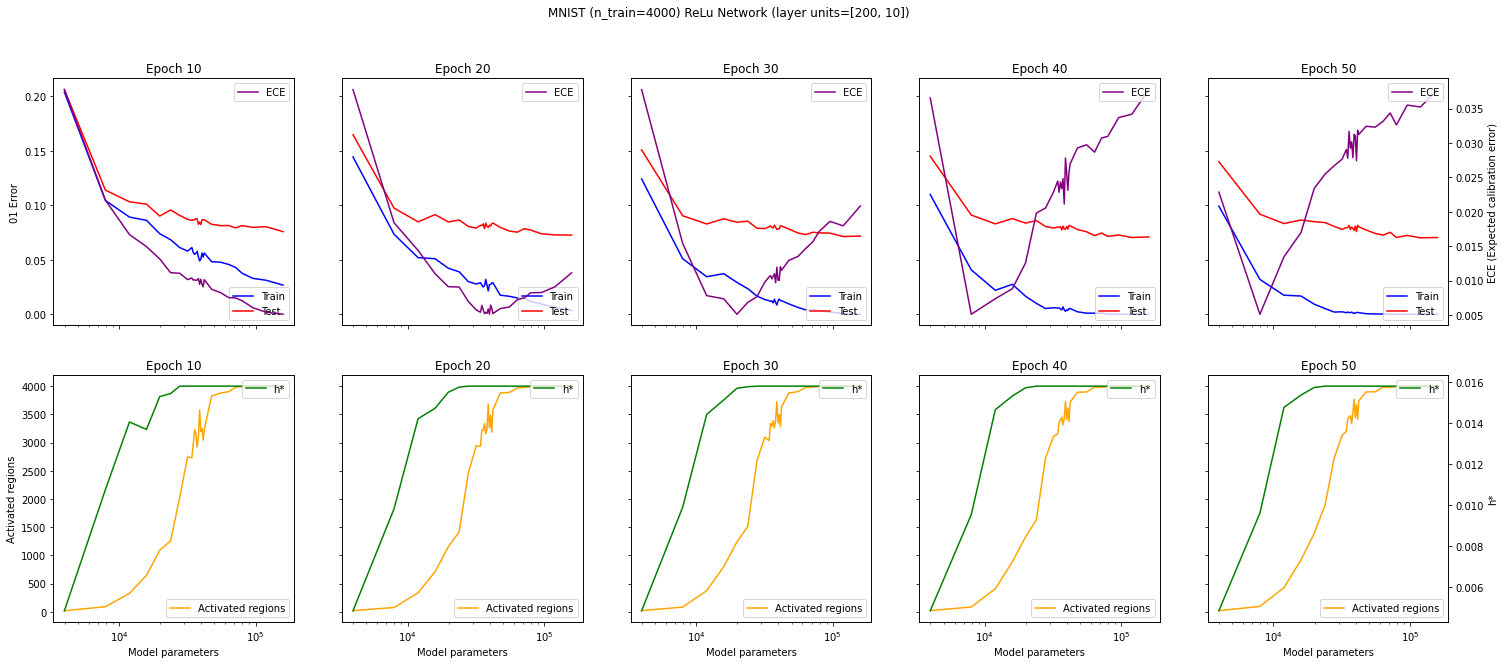

In [41]:
h_key = 'h*' # 'h_argmin'

total_params = list(results_dict.keys())
train_error = 1 - np.asarray([results_dict[tp]['train_accuracy'] for tp in total_params])
test_error = 1 - np.asarray([results_dict[tp]['test_accuracy'] for tp in total_params])
h_stars = np.asarray([results_dict[tp][h_key] for tp in total_params])
regions = np.asarray([results_dict[tp]['n_activated_regions'] for tp in total_params])
eces = np.asarray([results_dict[tp]['test_ece'] for tp in total_params])

fig, (ax1, ax2) = plt.subplots(2, 5, figsize=(25, 10), sharex=True, sharey='row')
for i, ax in enumerate(ax1):
    ax.plot(total_params, train_error[:, i*10 + 9], c='blue', label='Train')
    ax.plot(total_params, test_error[:, i*10 + 9], c='red', label='Test')
    ax.legend(loc='lower right')
    ax.set_xscale('log')
    ax_twin = ax.twinx()
    ax_twin.plot(total_params, eces[:, i*10 + 9], c='purple', label='ECE')
    ax_twin.legend(loc='upper right')
    if i < len(ax1) - 1:
        ax_twin.set_yticks([])
    ax.set_title(f'Epoch {i*10 + 10}')
    ax.set_xticks([])
ax1[0].set_ylabel('01 Error')
ax_twin.set_ylabel('ECE (Expected calibration error)')

for i, ax in enumerate(ax2):
    ax.plot(total_params, regions[:, i*10 + 9], c='orange', label='Activated regions')
    ax.legend(loc='lower right')
    ax.set_xscale('log')
    ax_twin = ax.twinx()
    ax_twin.plot(total_params, h_stars[:, i*10 + 9], c='green', label=h_key)
    ax_twin.legend(loc='upper right')
    if i < len(ax2) - 1:
        ax_twin.set_yticks([])
    ax.set_title(f'Epoch {i*10 + 10}')
    ax.set_xlabel('Model parameters')
ax2[0].set_ylabel('Activated regions')
ax_twin.set_ylabel(h_key)

plt.suptitle(f'MNIST (n_train={n_train_sample}) ReLu Network (layer units={[l.weights[1].shape[0] for l in model.layers[1:]]})')
plt.show()

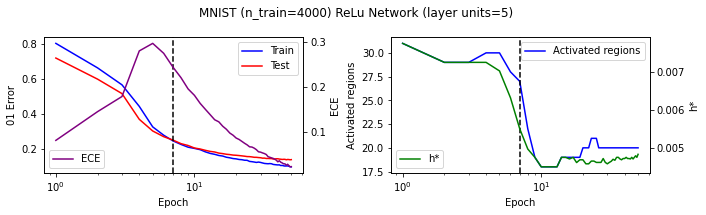

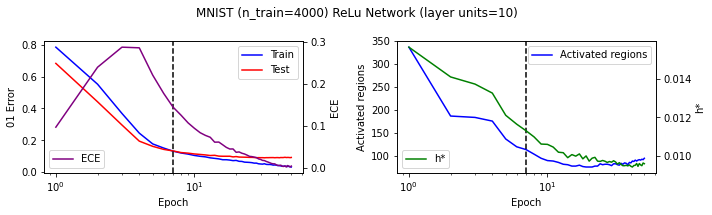

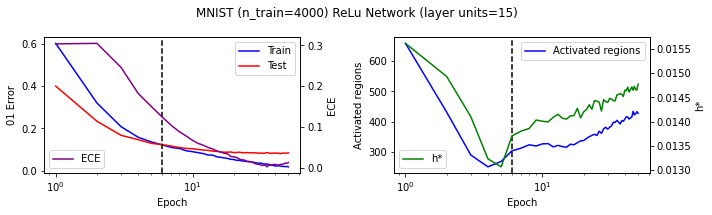

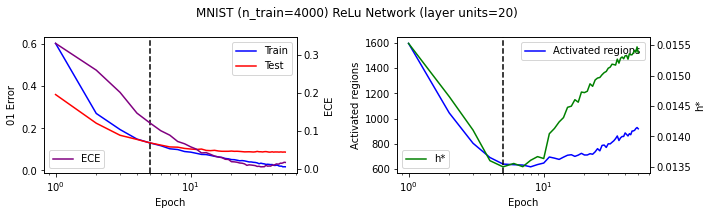

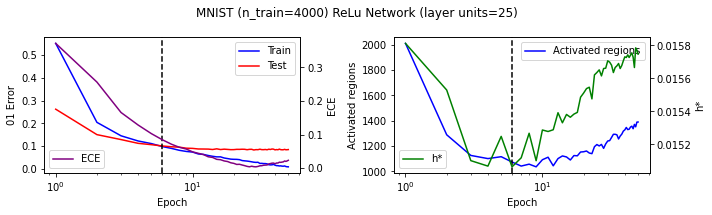

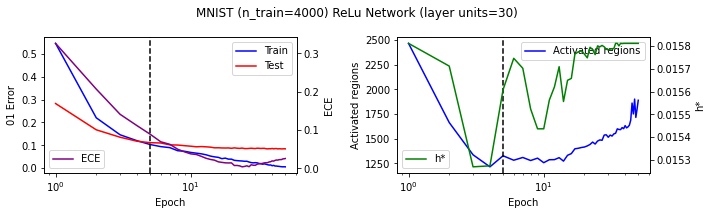

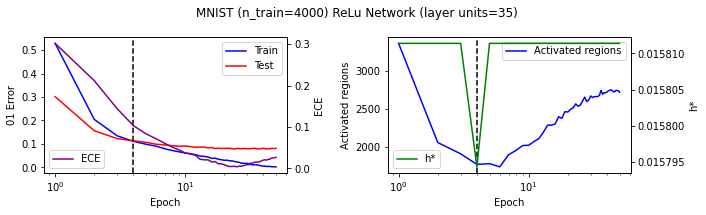

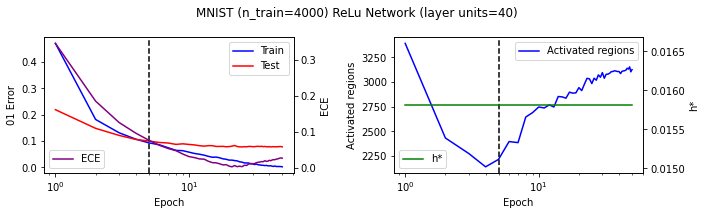

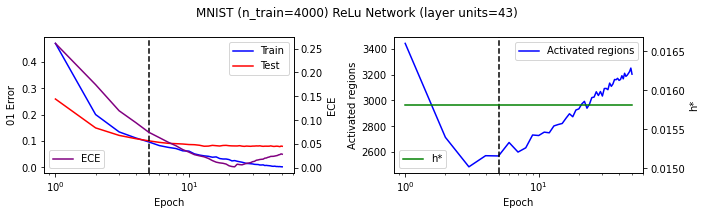

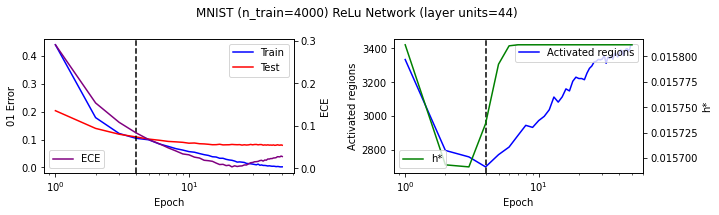

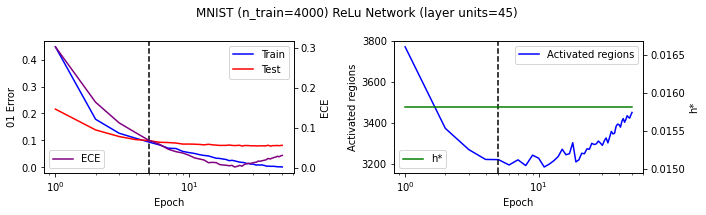

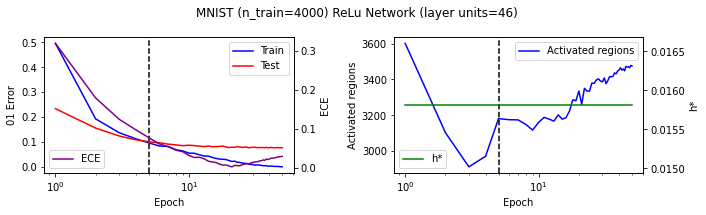

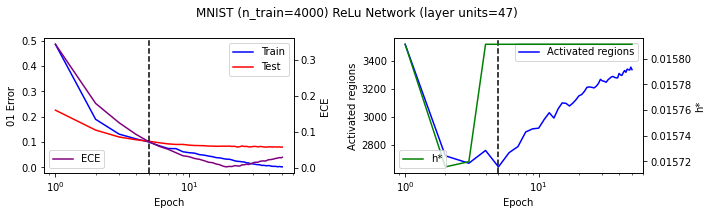

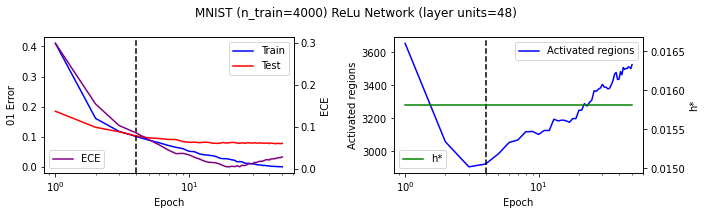

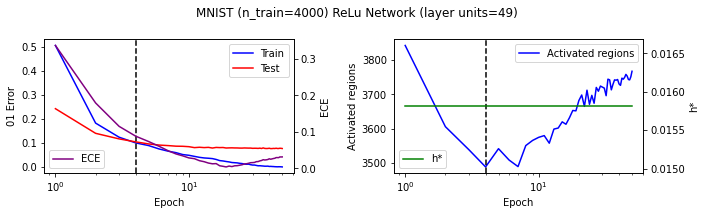

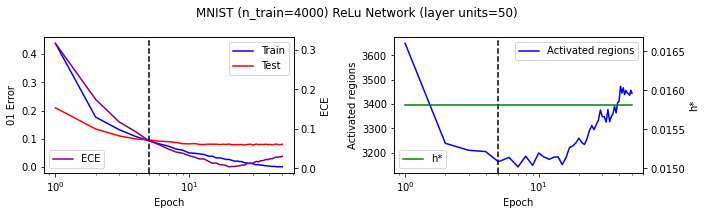

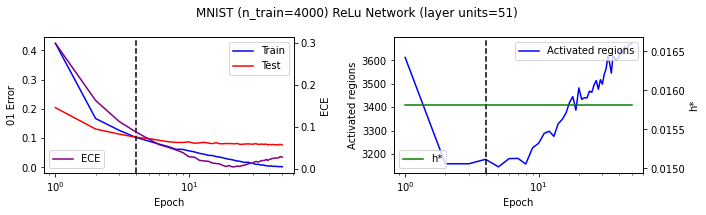

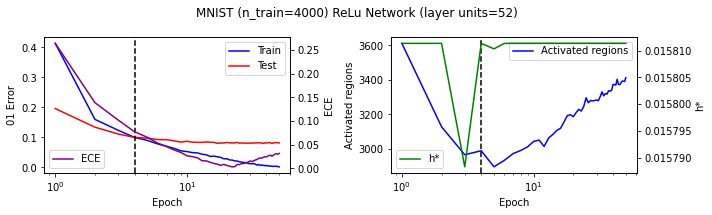

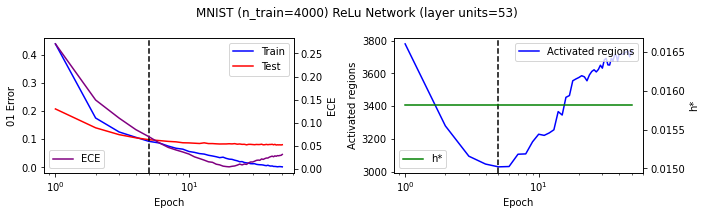

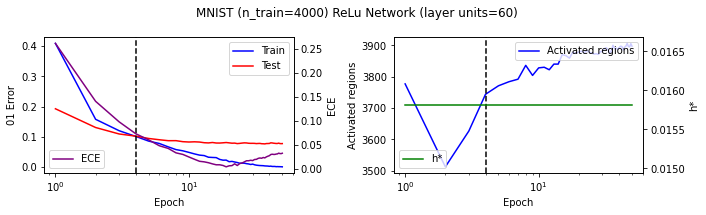

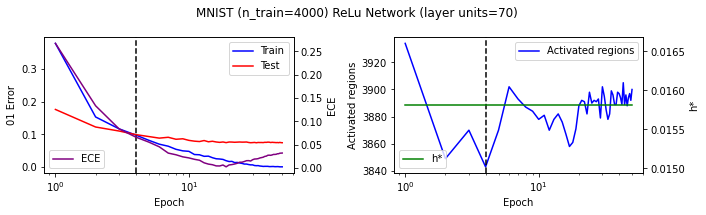

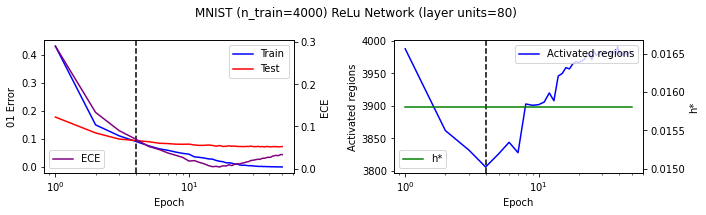

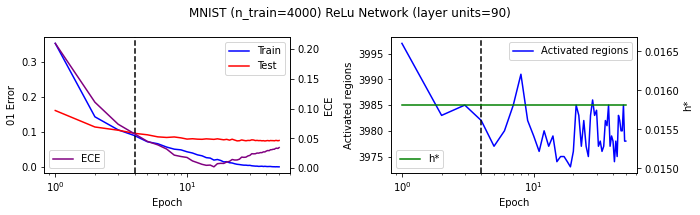

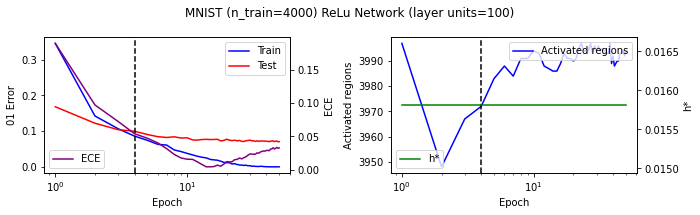

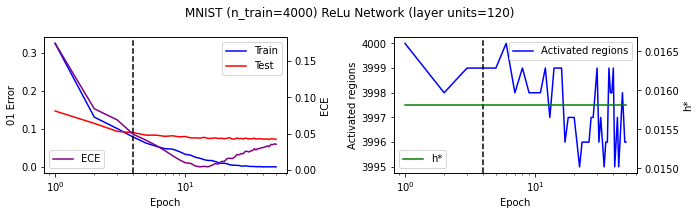

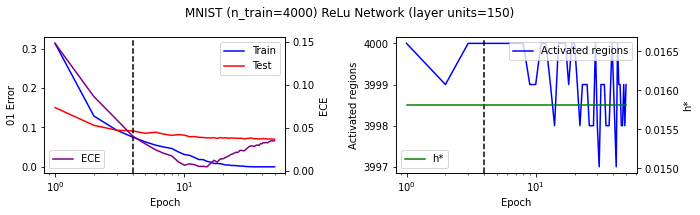

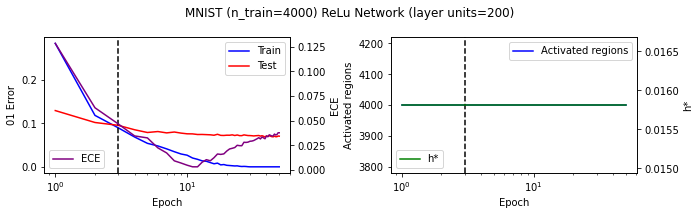

In [42]:
h_key = 'h*'# 'h_argmin'

for idx, tp in enumerate(results_dict.keys()):
    train_error = 1 - np.asarray(results_dict[tp]['train_accuracy'])
    test_error = 1 - np.asarray(results_dict[tp]['test_accuracy'])
    train_loss = np.asarray(results_dict[tp]['train_loss'])
    n_regions = results_dict[tp]['n_activated_regions']
    eces = results_dict[tp]['test_ece']

    epochs = np.arange(len(train_error)) + 1

    h_stars = results_dict[tp][h_key]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    # ax.plot(epochs, train_loss, c='blue', label='Train')
    ax1.plot(epochs, train_error, c='blue', label='Train')
    ax1.plot(epochs, test_error, c='red', label='Test')
    error_switch_epoch = epochs[np.argmax(train_error <= test_error)]
    ax1.legend(loc='upper right')
    ax1.set_xscale('log')
    ax1.set_ylabel('01 Error')
    ax1.set_xlabel('Epoch')
    ax1.axvline(error_switch_epoch, ls='--', c='black')

    ax1_twin = ax1.twinx()
    ax1_twin.plot(epochs, eces, c='purple', label='ECE')
    ax1_twin.legend(loc='lower left')
    ax1_twin.set_ylabel('ECE')
    
    ax2.plot(epochs, n_regions, c='blue', label='Activated regions')
    ax2.legend(loc='upper right')
    ax2.set_xlabel('Epoch')
    ax2.set_xscale('log')
    ax2.set_ylabel('Activated regions')
    ax2.axvline(error_switch_epoch, ls='--', c='black')

    ax2_twin = ax2.twinx()
    ax2_twin.plot(epochs, h_stars, c='green', label=h_key)
    ax2_twin.legend(loc='lower left')
    ax2_twin.set_ylabel(h_key)

    plt.suptitle(f'MNIST (n_train={n_train_sample}) ReLu Network (layer units={n_units_to_test[idx]})')
    plt.tight_layout()
    plt.show()

## Run CNN + penultimate

In [68]:
n_units_to_test = [5, 10, 15, 20, 25, 30, 40, 50, 100]

In [69]:
cnn_results_dict = {}
for n_units in tqdm(n_units_to_test):
    # CNN num_params = (width*height*prior_n_filters + 1) * n_filters
    total_cnn_params = (3*3*1+1)*8 + (3*3*8+1)*16 + (3*3*16+1)*16
    total_params = (3 * 3 * 16 + 1) * n_units + (n_units + 1) * 10 + total_cnn_params
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(8, (3, 3), activation='relu'),#, input_shape=(28, 28)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(n_units, activation='relu'),
        tf.keras.layers.Dense(10)
    ])
    
    n_epochs = 50
    optimizer = tf.keras.optimizers.Adam(0.001)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.SparseCategoricalAccuracy()
    
    model, model_results = fit_model(model, n_epochs, optimizer, loss_fn, metric)
    
    cnn_results_dict[total_params] = model_results

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 0: Training acc=0.221, Validation acc=0.310
Epoch 5: Training acc=0.569, Validation acc=0.581
Epoch 10: Training acc=0.725, Validation acc=0.744
Epoch 15: Training acc=0.803, Validation acc=0.797
Epoch 20: Training acc=0.840, Validation acc=0.823
Epoch 25: Training acc=0.884, Validation acc=0.892
Epoch 30: Training acc=0.921, Validation acc=0.914
Epoch 35: Training acc=0.937, Validation acc=0.924
Epoch 40: Training acc=0.949, Validation acc=0.927
Epoch 45: Training acc=0.959, Validation acc=0.934


 11%|█         | 1/9 [00:32<04:17, 32.21s/it]

Epoch 0: Training acc=0.219, Validation acc=0.308
Epoch 5: Training acc=0.859, Validation acc=0.881
Epoch 10: Training acc=0.924, Validation acc=0.916
Epoch 15: Training acc=0.949, Validation acc=0.938
Epoch 20: Training acc=0.961, Validation acc=0.946
Epoch 25: Training acc=0.968, Validation acc=0.952
Epoch 30: Training acc=0.970, Validation acc=0.957
Epoch 35: Training acc=0.979, Validation acc=0.958
Epoch 40: Training acc=0.980, Validation acc=0.953
Epoch 45: Training acc=0.986, Validation acc=0.955


 22%|██▏       | 2/9 [01:03<03:43, 31.92s/it]

Epoch 0: Training acc=0.255, Validation acc=0.365
Epoch 5: Training acc=0.856, Validation acc=0.870
Epoch 10: Training acc=0.911, Validation acc=0.917
Epoch 15: Training acc=0.934, Validation acc=0.928
Epoch 20: Training acc=0.955, Validation acc=0.941
Epoch 25: Training acc=0.963, Validation acc=0.946
Epoch 30: Training acc=0.974, Validation acc=0.955
Epoch 35: Training acc=0.978, Validation acc=0.951
Epoch 40: Training acc=0.984, Validation acc=0.952
Epoch 45: Training acc=0.987, Validation acc=0.955


 33%|███▎      | 3/9 [01:35<03:10, 31.82s/it]

Epoch 0: Training acc=0.242, Validation acc=0.392
Epoch 5: Training acc=0.910, Validation acc=0.919
Epoch 10: Training acc=0.947, Validation acc=0.948
Epoch 15: Training acc=0.967, Validation acc=0.956
Epoch 20: Training acc=0.973, Validation acc=0.957
Epoch 25: Training acc=0.979, Validation acc=0.960
Epoch 30: Training acc=0.984, Validation acc=0.963
Epoch 35: Training acc=0.987, Validation acc=0.963
Epoch 40: Training acc=0.992, Validation acc=0.961
Epoch 45: Training acc=0.996, Validation acc=0.965


 44%|████▍     | 4/9 [02:07<02:39, 31.98s/it]

Epoch 0: Training acc=0.174, Validation acc=0.258
Epoch 5: Training acc=0.906, Validation acc=0.919
Epoch 10: Training acc=0.938, Validation acc=0.937
Epoch 15: Training acc=0.960, Validation acc=0.946
Epoch 20: Training acc=0.968, Validation acc=0.951
Epoch 25: Training acc=0.975, Validation acc=0.953
Epoch 30: Training acc=0.983, Validation acc=0.957
Epoch 35: Training acc=0.985, Validation acc=0.957
Epoch 40: Training acc=0.985, Validation acc=0.958
Epoch 45: Training acc=0.994, Validation acc=0.958


 56%|█████▌    | 5/9 [02:40<02:08, 32.17s/it]

Epoch 0: Training acc=0.176, Validation acc=0.392
Epoch 5: Training acc=0.869, Validation acc=0.883
Epoch 10: Training acc=0.927, Validation acc=0.927
Epoch 15: Training acc=0.948, Validation acc=0.942
Epoch 20: Training acc=0.964, Validation acc=0.952
Epoch 25: Training acc=0.972, Validation acc=0.950
Epoch 30: Training acc=0.979, Validation acc=0.956
Epoch 35: Training acc=0.984, Validation acc=0.959
Epoch 40: Training acc=0.992, Validation acc=0.960
Epoch 45: Training acc=0.993, Validation acc=0.961


 67%|██████▋   | 6/9 [03:12<01:36, 32.25s/it]

Epoch 0: Training acc=0.305, Validation acc=0.562
Epoch 5: Training acc=0.902, Validation acc=0.905
Epoch 10: Training acc=0.944, Validation acc=0.934
Epoch 15: Training acc=0.962, Validation acc=0.944
Epoch 20: Training acc=0.975, Validation acc=0.955
Epoch 25: Training acc=0.981, Validation acc=0.960
Epoch 30: Training acc=0.985, Validation acc=0.959
Epoch 35: Training acc=0.990, Validation acc=0.961
Epoch 40: Training acc=0.993, Validation acc=0.963
Epoch 45: Training acc=0.993, Validation acc=0.961


 78%|███████▊  | 7/9 [03:46<01:05, 32.60s/it]

Epoch 0: Training acc=0.275, Validation acc=0.482
Epoch 5: Training acc=0.920, Validation acc=0.918
Epoch 10: Training acc=0.958, Validation acc=0.935
Epoch 15: Training acc=0.971, Validation acc=0.954
Epoch 20: Training acc=0.983, Validation acc=0.960
Epoch 25: Training acc=0.988, Validation acc=0.961
Epoch 30: Training acc=0.989, Validation acc=0.965
Epoch 35: Training acc=0.994, Validation acc=0.966
Epoch 40: Training acc=0.998, Validation acc=0.966
Epoch 45: Training acc=0.999, Validation acc=0.967


 89%|████████▉ | 8/9 [04:19<00:32, 32.91s/it]

Epoch 0: Training acc=0.455, Validation acc=0.720
Epoch 5: Training acc=0.923, Validation acc=0.927
Epoch 10: Training acc=0.961, Validation acc=0.952
Epoch 15: Training acc=0.971, Validation acc=0.962
Epoch 20: Training acc=0.984, Validation acc=0.964
Epoch 25: Training acc=0.992, Validation acc=0.966
Epoch 30: Training acc=0.995, Validation acc=0.966
Epoch 35: Training acc=0.996, Validation acc=0.966
Epoch 40: Training acc=0.998, Validation acc=0.966
Epoch 45: Training acc=1.000, Validation acc=0.968


100%|██████████| 9/9 [04:54<00:00, 32.75s/it]


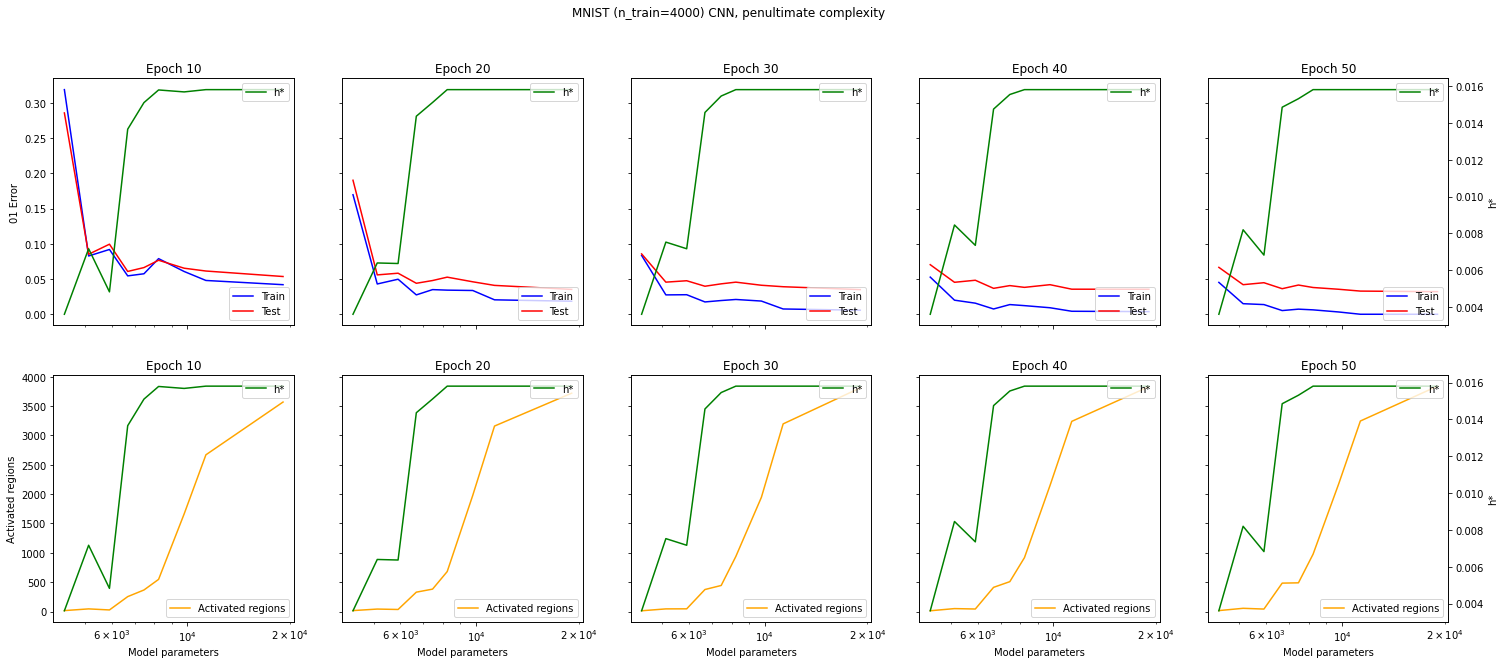

In [71]:
total_params = list(cnn_results_dict.keys())
train_error = 1 - np.asarray([cnn_results_dict[tp]['train_accuracy'] for tp in total_params])
test_error = 1 - np.asarray([cnn_results_dict[tp]['test_accuracy'] for tp in total_params])
h_stars = np.asarray([cnn_results_dict[tp]['h*'] for tp in total_params])
regions = np.asarray([cnn_results_dict[tp]['n_activated_regions'] for tp in total_params])

fig, (ax1, ax2) = plt.subplots(2, 5, figsize=(25, 10), sharex=True, sharey='row')
for i, ax in enumerate(ax1):
    ax.plot(total_params, train_error[:, i*10 + 9], c='blue', label='Train')
    ax.plot(total_params, test_error[:, i*10 + 9], c='red', label='Test')
    ax.legend(loc='lower right')
    ax.set_xscale('log')
    ax_twin = ax.twinx()
    ax_twin.plot(total_params, h_stars[:, i*10 + 9], c='green', label='h*')
    ax_twin.legend(loc='upper right')
    if i < len(ax1) - 1:
        ax_twin.set_yticks([])
    ax.set_title(f'Epoch {i*10 + 10}')
    ax.set_xticks([])
ax1[0].set_ylabel('01 Error')
ax_twin.set_ylabel('h*')

for i, ax in enumerate(ax2):
    ax.plot(total_params, regions[:, i*10 + 9], c='orange', label='Activated regions')
    ax.legend(loc='lower right')
    ax.set_xscale('log')
    ax_twin = ax.twinx()
    ax_twin.plot(total_params, h_stars[:, i*10 + 9], c='green', label='h*')
    ax_twin.legend(loc='upper right')
    if i < len(ax2) - 1:
        ax_twin.set_yticks([])
    ax.set_title(f'Epoch {i*10 + 10}')
    ax.set_xlabel('Model parameters')
ax2[0].set_ylabel('Activated regions')
ax_twin.set_ylabel('h*')

plt.suptitle(f'MNIST (n_train={n_train_sample}) CNN, penultimate complexity')
plt.show()

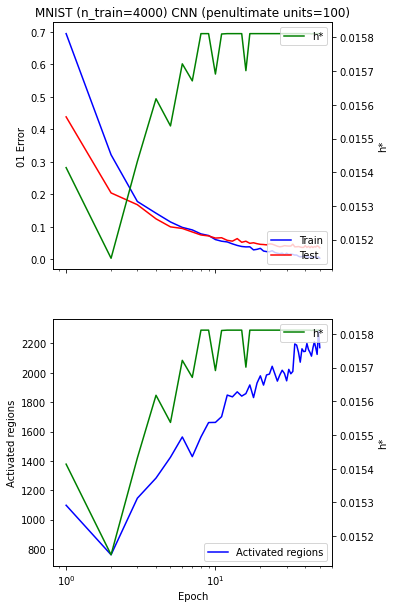

In [80]:
tp = list(cnn_results_dict.keys())[6]
train_error = 1 - np.asarray(cnn_results_dict[tp]['train_accuracy'])
test_error = 1 - np.asarray(cnn_results_dict[tp]['test_accuracy'])
train_loss = np.asarray(cnn_results_dict[tp]['train_loss'])
n_regions = cnn_results_dict[tp]['n_activated_regions']
epochs = np.arange(len(train_error)) + 1

h_stars = cnn_results_dict[tp]['h*']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 10), sharex=True)
# ax.plot(epochs, train_loss, c='blue', label='Train')
ax1.plot(epochs, train_error, c='blue', label='Train')
ax1.plot(epochs, test_error, c='red', label='Test')
ax1.legend(loc='lower right')
ax1.set_xscale('log')
ax1.set_ylabel('01 Error')

ax1_twin = ax1.twinx()
ax1_twin.plot(epochs, h_stars, c='green', label='h*')
ax1_twin.legend(loc='upper right')
ax1_twin.set_ylabel('h*')

ax2.plot(epochs, n_regions, c='blue', label='Activated regions')
ax2.legend(loc='lower right')
ax2.set_xlabel('Epoch')
ax2.set_xscale('log')
ax2.set_ylabel('Activated regions')

ax2_twin = ax2.twinx()
ax2_twin.plot(epochs, h_stars, c='green', label='h*')
ax2_twin.legend(loc='upper right')
ax2_twin.set_ylabel('h*')

ax1.set_title(f'MNIST (n_train={n_train_sample}) CNN (penultimate units={model.layers[-2].weights[1].shape[0]})')
plt.show()

### Modify the backbone

In [81]:
n_filters_to_test = [1, 2, 4, 8, 12, 16]
n_units = 20

cnn_back_results_dict = {}
for n_filters in tqdm(n_filters_to_test):
    # CNN num_params = (width*height*prior_n_filters + 1) * n_filters
    total_cnn_params = (3*3*1+1)*n_filters + (3*3*n_filters+1)*n_filters*2 + (3*3*16+1)*n_filters*2
    total_params = (3 * 3 * n_filters*2 + 1) * n_units + (n_units + 1) * 10 + total_cnn_params
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(n_filters, (3, 3), activation='relu'),#, input_shape=(28, 28)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(n_filters*2, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(n_filters*2, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(n_units, activation='relu'),
        tf.keras.layers.Dense(10)
    ])
    
    n_epochs = 50
    optimizer = tf.keras.optimizers.Adam(0.001)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.SparseCategoricalAccuracy()
    
    model, model_results = fit_model(model, n_epochs, optimizer, loss_fn, metric)
    
    cnn_back_results_dict[total_params] = model_results

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 0: Training acc=0.141, Validation acc=0.207
Epoch 5: Training acc=0.610, Validation acc=0.643
Epoch 10: Training acc=0.741, Validation acc=0.748
Epoch 15: Training acc=0.782, Validation acc=0.795
Epoch 20: Training acc=0.812, Validation acc=0.819
Epoch 25: Training acc=0.828, Validation acc=0.826
Epoch 30: Training acc=0.840, Validation acc=0.840
Epoch 35: Training acc=0.853, Validation acc=0.848
Epoch 40: Training acc=0.857, Validation acc=0.853
Epoch 45: Training acc=0.857, Validation acc=0.856


 17%|█▋        | 1/6 [01:13<06:08, 73.74s/it]

Epoch 0: Training acc=0.087, Validation acc=0.142
Epoch 5: Training acc=0.750, Validation acc=0.779
Epoch 10: Training acc=0.840, Validation acc=0.849
Epoch 15: Training acc=0.873, Validation acc=0.876
Epoch 20: Training acc=0.893, Validation acc=0.891
Epoch 25: Training acc=0.907, Validation acc=0.901
Epoch 30: Training acc=0.918, Validation acc=0.910
Epoch 35: Training acc=0.927, Validation acc=0.916
Epoch 40: Training acc=0.928, Validation acc=0.918
Epoch 45: Training acc=0.940, Validation acc=0.923


 33%|███▎      | 2/6 [02:19<04:37, 69.26s/it]

Epoch 0: Training acc=0.152, Validation acc=0.222
Epoch 5: Training acc=0.798, Validation acc=0.825
Epoch 10: Training acc=0.901, Validation acc=0.911
Epoch 15: Training acc=0.928, Validation acc=0.923
Epoch 20: Training acc=0.938, Validation acc=0.930
Epoch 25: Training acc=0.942, Validation acc=0.930
Epoch 30: Training acc=0.949, Validation acc=0.943
Epoch 35: Training acc=0.953, Validation acc=0.945
Epoch 40: Training acc=0.959, Validation acc=0.949
Epoch 45: Training acc=0.961, Validation acc=0.949


 50%|█████     | 3/6 [03:04<02:53, 57.91s/it]

Epoch 0: Training acc=0.217, Validation acc=0.296
Epoch 5: Training acc=0.888, Validation acc=0.904
Epoch 10: Training acc=0.939, Validation acc=0.928
Epoch 15: Training acc=0.964, Validation acc=0.948
Epoch 20: Training acc=0.973, Validation acc=0.958
Epoch 25: Training acc=0.978, Validation acc=0.957
Epoch 30: Training acc=0.983, Validation acc=0.959
Epoch 35: Training acc=0.984, Validation acc=0.962
Epoch 40: Training acc=0.990, Validation acc=0.960
Epoch 45: Training acc=0.992, Validation acc=0.964


 67%|██████▋   | 4/6 [03:36<01:35, 47.71s/it]

Epoch 0: Training acc=0.333, Validation acc=0.509
Epoch 5: Training acc=0.927, Validation acc=0.937
Epoch 10: Training acc=0.957, Validation acc=0.948
Epoch 15: Training acc=0.970, Validation acc=0.955
Epoch 20: Training acc=0.978, Validation acc=0.959
Epoch 25: Training acc=0.980, Validation acc=0.961
Epoch 30: Training acc=0.987, Validation acc=0.963
Epoch 35: Training acc=0.983, Validation acc=0.962
Epoch 40: Training acc=0.997, Validation acc=0.965
Epoch 45: Training acc=0.998, Validation acc=0.962


 83%|████████▎ | 5/6 [04:07<00:41, 41.67s/it]

Epoch 0: Training acc=0.306, Validation acc=0.571
Epoch 5: Training acc=0.935, Validation acc=0.934
Epoch 10: Training acc=0.970, Validation acc=0.952
Epoch 15: Training acc=0.982, Validation acc=0.964
Epoch 20: Training acc=0.991, Validation acc=0.965
Epoch 25: Training acc=0.995, Validation acc=0.966
Epoch 30: Training acc=0.998, Validation acc=0.969
Epoch 35: Training acc=0.999, Validation acc=0.970
Epoch 40: Training acc=1.000, Validation acc=0.971
Epoch 45: Training acc=1.000, Validation acc=0.971


100%|██████████| 6/6 [04:38<00:00, 46.39s/it]


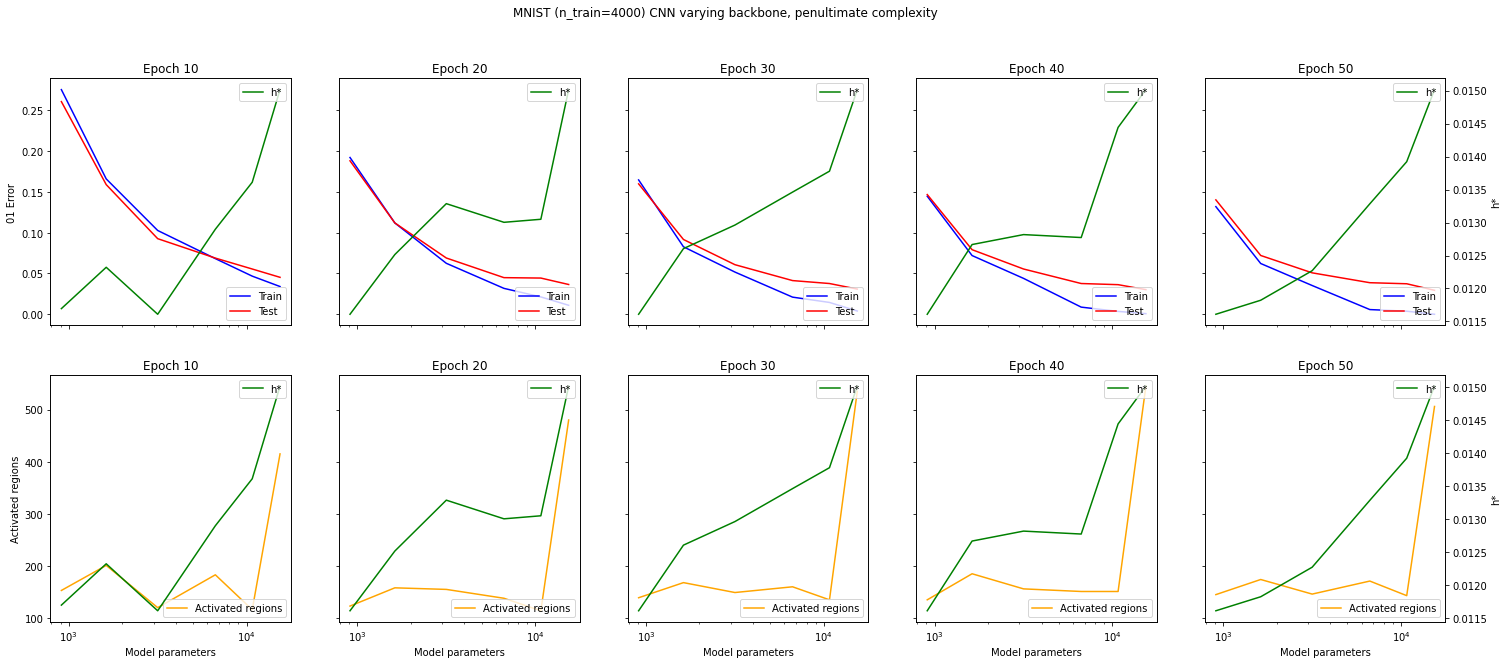

In [82]:
total_params = list(cnn_back_results_dict.keys())
train_error = 1 - np.asarray([cnn_back_results_dict[tp]['train_accuracy'] for tp in total_params])
test_error = 1 - np.asarray([cnn_back_results_dict[tp]['test_accuracy'] for tp in total_params])
h_stars = np.asarray([cnn_back_results_dict[tp]['h*'] for tp in total_params])
regions = np.asarray([cnn_back_results_dict[tp]['n_activated_regions'] for tp in total_params])

fig, (ax1, ax2) = plt.subplots(2, 5, figsize=(25, 10), sharex=True, sharey='row')
for i, ax in enumerate(ax1):
    ax.plot(total_params, train_error[:, i*10 + 9], c='blue', label='Train')
    ax.plot(total_params, test_error[:, i*10 + 9], c='red', label='Test')
    ax.legend(loc='lower right')
    ax.set_xscale('log')
    ax_twin = ax.twinx()
    ax_twin.plot(total_params, h_stars[:, i*10 + 9], c='green', label='h*')
    ax_twin.legend(loc='upper right')
    if i < len(ax1) - 1:
        ax_twin.set_yticks([])
    ax.set_title(f'Epoch {i*10 + 10}')
    ax.set_xticks([])
ax1[0].set_ylabel('01 Error')
ax_twin.set_ylabel('h*')

for i, ax in enumerate(ax2):
    ax.plot(total_params, regions[:, i*10 + 9], c='orange', label='Activated regions')
    ax.legend(loc='lower right')
    ax.set_xscale('log')
    ax_twin = ax.twinx()
    ax_twin.plot(total_params, h_stars[:, i*10 + 9], c='green', label='h*')
    ax_twin.legend(loc='upper right')
    if i < len(ax2) - 1:
        ax_twin.set_yticks([])
    ax.set_title(f'Epoch {i*10 + 10}')
    ax.set_xlabel('Model parameters')
ax2[0].set_ylabel('Activated regions')
ax_twin.set_ylabel('h*')

plt.suptitle(f'MNIST (n_train={n_train_sample}) CNN varying backbone, penultimate complexity')
plt.show()

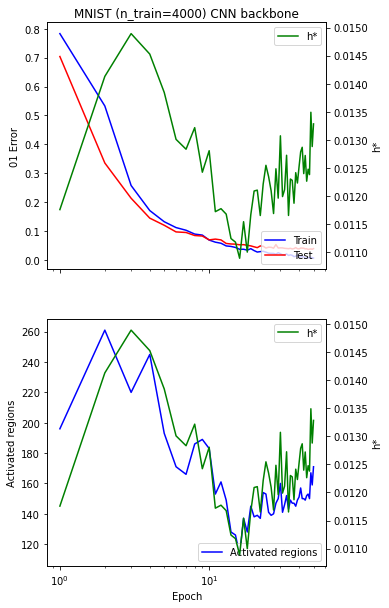

In [90]:
tp = list(cnn_back_results_dict.keys())[3]
train_error = 1 - np.asarray(cnn_back_results_dict[tp]['train_accuracy'])
test_error = 1 - np.asarray(cnn_back_results_dict[tp]['test_accuracy'])
train_loss = np.asarray(cnn_back_results_dict[tp]['train_loss'])
n_regions = cnn_back_results_dict[tp]['n_activated_regions']
h_stars = cnn_back_results_dict[tp]['h*']
epochs = np.arange(len(train_error)) + 1

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 10), sharex=True)
# ax.plot(epochs, train_loss, c='blue', label='Train')
ax1.plot(epochs, train_error, c='blue', label='Train')
ax1.plot(epochs, test_error, c='red', label='Test')
ax1.legend(loc='lower right')
ax1.set_xscale('log')
ax1.set_ylabel('01 Error')

ax1_twin = ax1.twinx()
ax1_twin.plot(epochs, h_stars, c='green', label='h*')
ax1_twin.legend(loc='upper right')
ax1_twin.set_ylabel('h*')

ax2.plot(epochs, n_regions, c='blue', label='Activated regions')
ax2.legend(loc='lower right')
ax2.set_xlabel('Epoch')
ax2.set_xscale('log')
ax2.set_ylabel('Activated regions')

ax2_twin = ax2.twinx()
ax2_twin.plot(epochs, h_stars, c='green', label='h*')
ax2_twin.legend(loc='upper right')
ax2_twin.set_ylabel('h*')

ax1.set_title(f'MNIST (n_train={n_train_sample}) CNN backbone')
plt.show()

## CNN o Cifar10

In [94]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
    data_dir='/mnt/ssd3/ronan/tensorflow_datasets/',
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling cifar10-train.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling cifar10-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /mnt/ssd3/ronan/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [95]:
n_train_sample = 10000
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

# Train pipeline
ds_train = ds_train.take(n_train_sample)
ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

# Test pipeline
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [98]:
n_filters_to_test = [2, 4, 8, 16, 32]
n_units = 64
input_shape = (32, 32, 3)

cnn_cifar_results_dict = {}
for n_filters in tqdm(n_filters_to_test):
    # CNN num_params = (width*height*prior_n_filters + 1) * n_filters
    total_cnn_params = (3*3*input_shape[-3]+1)*n_filters + (3*3*n_filters+1)*n_filters*2 + (3*3*16+1)*n_filters*2
    total_params = (3 * 3 * n_filters*2 + 1) * n_units + (n_units + 1) * 10 + total_cnn_params
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(n_filters, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(n_filters*2, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(n_filters*2, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(n_units, activation='relu'),
        tf.keras.layers.Dense(10)
    ])
    
    n_epochs = 100
    optimizer = tf.keras.optimizers.Adam(0.001)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.SparseCategoricalAccuracy()
    
    model, model_results = fit_model(model, n_epochs, optimizer, loss_fn, metric)
    
    cnn_cifar_results_dict[total_params] = model_results


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0: Training acc=0.143, Validation acc=0.182
Epoch 5: Training acc=0.315, Validation acc=0.299
Epoch 10: Training acc=0.356, Validation acc=0.332
Epoch 15: Training acc=0.390, Validation acc=0.366
Epoch 20: Training acc=0.405, Validation acc=0.388
Epoch 25: Training acc=0.424, Validation acc=0.397
Epoch 30: Training acc=0.431, Validation acc=0.394
Epoch 35: Training acc=0.441, Validation acc=0.408
Epoch 40: Training acc=0.451, Validation acc=0.414
Epoch 45: Training acc=0.456, Validation acc=0.422
Epoch 50: Training acc=0.465, Validation acc=0.416
Epoch 55: Training acc=0.468, Validation acc=0.419
Epoch 60: Training acc=0.477, Validation acc=0.420
Epoch 65: Training acc=0.477, Validation acc=0.432
Epoch 70: Training acc=0.484, Validation acc=0.428
Epoch 75: Training acc=0.497, Validation acc=0.429
Epoch 80: Training acc=0.500, Validation acc=0.427
Epoch 85: Training acc=0.499, Validation acc=0.430
Epoch 90: Training acc=0.502, Validation acc=0.429
Epoch 95: Training acc=0.505, Val


 20%|██        | 1/5 [03:47<15:10, 227.64s/it]

Epoch 0: Training acc=0.158, Validation acc=0.230
Epoch 5: Training acc=0.391, Validation acc=0.389
Epoch 10: Training acc=0.435, Validation acc=0.435
Epoch 15: Training acc=0.463, Validation acc=0.446
Epoch 20: Training acc=0.492, Validation acc=0.464
Epoch 25: Training acc=0.509, Validation acc=0.471
Epoch 30: Training acc=0.526, Validation acc=0.480
Epoch 35: Training acc=0.539, Validation acc=0.486
Epoch 40: Training acc=0.545, Validation acc=0.488
Epoch 45: Training acc=0.558, Validation acc=0.494
Epoch 50: Training acc=0.567, Validation acc=0.490
Epoch 55: Training acc=0.583, Validation acc=0.498
Epoch 60: Training acc=0.582, Validation acc=0.475
Epoch 65: Training acc=0.592, Validation acc=0.499
Epoch 70: Training acc=0.601, Validation acc=0.497
Epoch 75: Training acc=0.603, Validation acc=0.477
Epoch 80: Training acc=0.618, Validation acc=0.502
Epoch 85: Training acc=0.619, Validation acc=0.494
Epoch 90: Training acc=0.627, Validation acc=0.504
Epoch 95: Training acc=0.628, Val


 40%|████      | 2/5 [06:36<09:38, 192.90s/it]

Epoch 0: Training acc=0.199, Validation acc=0.298
Epoch 5: Training acc=0.443, Validation acc=0.444
Epoch 10: Training acc=0.501, Validation acc=0.493
Epoch 15: Training acc=0.538, Validation acc=0.501
Epoch 20: Training acc=0.559, Validation acc=0.526
Epoch 25: Training acc=0.588, Validation acc=0.533
Epoch 30: Training acc=0.608, Validation acc=0.543
Epoch 35: Training acc=0.619, Validation acc=0.531
Epoch 40: Training acc=0.639, Validation acc=0.537
Epoch 45: Training acc=0.651, Validation acc=0.549
Epoch 50: Training acc=0.653, Validation acc=0.561
Epoch 55: Training acc=0.682, Validation acc=0.561
Epoch 60: Training acc=0.693, Validation acc=0.559
Epoch 65: Training acc=0.706, Validation acc=0.554
Epoch 70: Training acc=0.722, Validation acc=0.566
Epoch 75: Training acc=0.734, Validation acc=0.561
Epoch 80: Training acc=0.738, Validation acc=0.564
Epoch 85: Training acc=0.757, Validation acc=0.562
Epoch 90: Training acc=0.768, Validation acc=0.556
Epoch 95: Training acc=0.775, Val


 60%|██████    | 3/5 [08:47<05:29, 164.58s/it]

Epoch 0: Training acc=0.237, Validation acc=0.327
Epoch 5: Training acc=0.464, Validation acc=0.475
Epoch 10: Training acc=0.549, Validation acc=0.529
Epoch 15: Training acc=0.587, Validation acc=0.552
Epoch 20: Training acc=0.631, Validation acc=0.564
Epoch 25: Training acc=0.673, Validation acc=0.579
Epoch 30: Training acc=0.697, Validation acc=0.587
Epoch 35: Training acc=0.723, Validation acc=0.592
Epoch 40: Training acc=0.765, Validation acc=0.597
Epoch 45: Training acc=0.776, Validation acc=0.602
Epoch 50: Training acc=0.808, Validation acc=0.576
Epoch 55: Training acc=0.837, Validation acc=0.589
Epoch 60: Training acc=0.854, Validation acc=0.587
Epoch 65: Training acc=0.885, Validation acc=0.581
Epoch 70: Training acc=0.902, Validation acc=0.583
Epoch 75: Training acc=0.920, Validation acc=0.574
Epoch 80: Training acc=0.942, Validation acc=0.574
Epoch 85: Training acc=0.950, Validation acc=0.573
Epoch 90: Training acc=0.964, Validation acc=0.576
Epoch 95: Training acc=0.967, Val


 80%|████████  | 4/5 [11:05<02:34, 154.17s/it]

Epoch 0: Training acc=0.238, Validation acc=0.307
Epoch 5: Training acc=0.499, Validation acc=0.484
Epoch 10: Training acc=0.581, Validation acc=0.558
Epoch 15: Training acc=0.652, Validation acc=0.595
Epoch 20: Training acc=0.706, Validation acc=0.596
Epoch 25: Training acc=0.752, Validation acc=0.613
Epoch 30: Training acc=0.803, Validation acc=0.599
Epoch 35: Training acc=0.850, Validation acc=0.589
Epoch 40: Training acc=0.895, Validation acc=0.614
Epoch 45: Training acc=0.932, Validation acc=0.602
Epoch 50: Training acc=0.960, Validation acc=0.607
Epoch 55: Training acc=0.977, Validation acc=0.579
Epoch 60: Training acc=0.990, Validation acc=0.603
Epoch 65: Training acc=0.999, Validation acc=0.600
Epoch 70: Training acc=0.999, Validation acc=0.591
Epoch 75: Training acc=0.988, Validation acc=0.595
Epoch 80: Training acc=1.000, Validation acc=0.603
Epoch 85: Training acc=1.000, Validation acc=0.602
Epoch 90: Training acc=1.000, Validation acc=0.602
Epoch 95: Training acc=1.000, Val


100%|██████████| 5/5 [14:06<00:00, 169.30s/it]


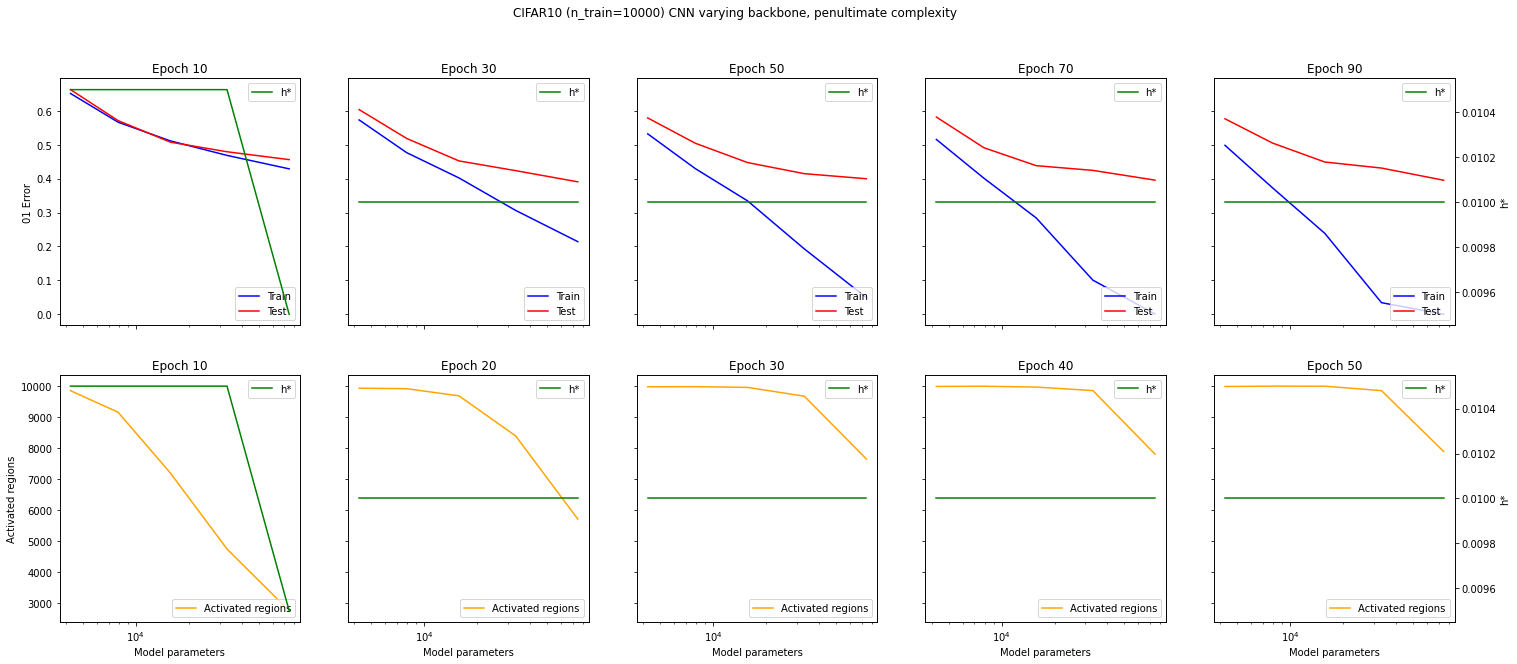

In [116]:
total_params = list(cnn_cifar_results_dict.keys())
train_error = 1 - np.asarray([cnn_cifar_results_dict[tp]['train_accuracy'] for tp in total_params])
test_error = 1 - np.asarray([cnn_cifar_results_dict[tp]['test_accuracy'] for tp in total_params])
h_stars = np.asarray([cnn_cifar_results_dict[tp]['h*'] for tp in total_params])
regions = np.asarray([cnn_cifar_results_dict[tp]['n_activated_regions'] for tp in total_params])

fig, (ax1, ax2) = plt.subplots(2, 5, figsize=(25, 10), sharex=True, sharey='row')
for i, ax in enumerate(ax1):
    ax.plot(total_params, train_error[:, i*20 + 9], c='blue', label='Train')
    ax.plot(total_params, test_error[:, i*20 + 9], c='red', label='Test')
    ax.legend(loc='lower right')
    ax.set_xscale('log')
    ax_twin = ax.twinx()
    ax_twin.plot(total_params, h_stars[:, i*20 + 9], c='green', label='h*')
    ax_twin.legend(loc='upper right')
    if i < len(ax1) - 1:
        ax_twin.set_yticks([])
    ax.set_title(f'Epoch {i*20 + 10}')
    ax.set_xticks([])
ax1[0].set_ylabel('01 Error')
ax_twin.set_ylabel('h*')

for i, ax in enumerate(ax2):
    ax.plot(total_params, regions[:, i*20 + 9], c='orange', label='Activated regions')
    ax.legend(loc='lower right')
    ax.set_xscale('log')
    ax_twin = ax.twinx()
    ax_twin.plot(total_params, h_stars[:, i*20 + 9], c='green', label='h*')
    ax_twin.legend(loc='upper right')
    if i < len(ax2) - 1:
        ax_twin.set_yticks([])
    ax.set_title(f'Epoch {i*10 + 10}')
    ax.set_xlabel('Model parameters')
ax2[0].set_ylabel('Activated regions')
ax_twin.set_ylabel('h*')

plt.suptitle(f'CIFAR10 (n_train={n_train_sample}) CNN varying backbone, penultimate complexity')
plt.show()

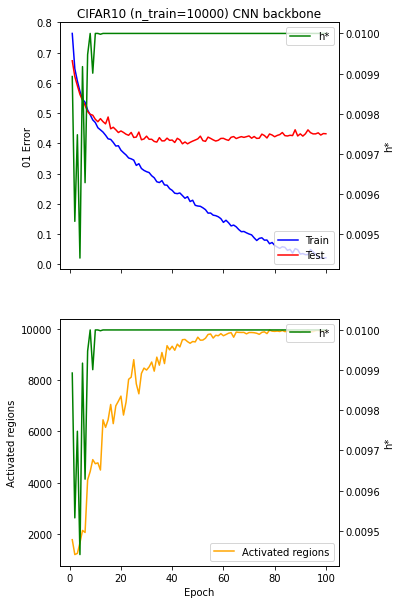

In [115]:
tp = list(cnn_cifar_results_dict.keys())[-2]
train_error = 1 - np.asarray(cnn_cifar_results_dict[tp]['train_accuracy'])
test_error = 1 - np.asarray(cnn_cifar_results_dict[tp]['test_accuracy'])
train_loss = np.asarray(cnn_cifar_results_dict[tp]['train_loss'])
n_regions = cnn_cifar_results_dict[tp]['n_activated_regions']
h_stars = cnn_cifar_results_dict[tp]['h*']
epochs = np.arange(len(train_error)) + 1

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 10), sharex=True)
# ax.plot(epochs, train_loss, c='blue', label='Train')
ax1.plot(epochs, train_error, c='blue', label='Train')
ax1.plot(epochs, test_error, c='red', label='Test')
ax1.legend(loc='lower right')
#ax1.set_xscale('log')
ax1.set_ylabel('01 Error')

ax1_twin = ax1.twinx()
ax1_twin.plot(epochs, h_stars, c='green', label='h*')
ax1_twin.legend(loc='upper right')
ax1_twin.set_ylabel('h*')

ax2.plot(epochs, n_regions, c='orange', label='Activated regions')
ax2.legend(loc='lower right')
ax2.set_xlabel('Epoch')
# ax2.set_xscale('log')
ax2.set_ylabel('Activated regions')

ax2_twin = ax2.twinx()
ax2_twin.plot(epochs, h_stars, c='green', label='h*')
ax2_twin.legend(loc='upper right')
ax2_twin.set_ylabel('h*')

ax1.set_title(f'CIFAR10 (n_train={n_train_sample}) CNN backbone')
plt.show()